<h5>Stock Market Data</h5>

In [125]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

read_file = pd.read_csv (r'05062020.txt', header = None)
read_file.columns = ['Time','ShareValue','Strike','CallSpread','PutSpread','CallPrice','PutPrice']
read_file.to_csv (r'05062020.csv', index=None)

df = pd.read_csv (r'05062020.csv')

In [126]:
requiredNodes = ['Time','ShareValue','CallSpread','PutSpread']
df.set_index([pd.Index(range(len(df)))])
result = df.loc[:, df.columns.isin(requiredNodes)]
result.set_index([pd.Index(range(len(df)))])
result=result.sort_index(ascending=True, axis=0)

#Data Aggregation 
print(result.describe(percentiles=None, include=None, exclude=None))

         ShareValue    CallSpread    PutSpread
count  27210.000000  27210.000000  27210.00000
mean   20717.559794      2.047053      2.61173
std      120.855224      3.969915      4.00761
min    20426.000000      0.880000      1.11000
25%    20627.000000      1.810000      2.23000
50%    20713.000000      2.000000      2.48000
75%    20791.000000      2.200000      2.79000
max    21050.000000    654.340000    652.98000


(0, 10)

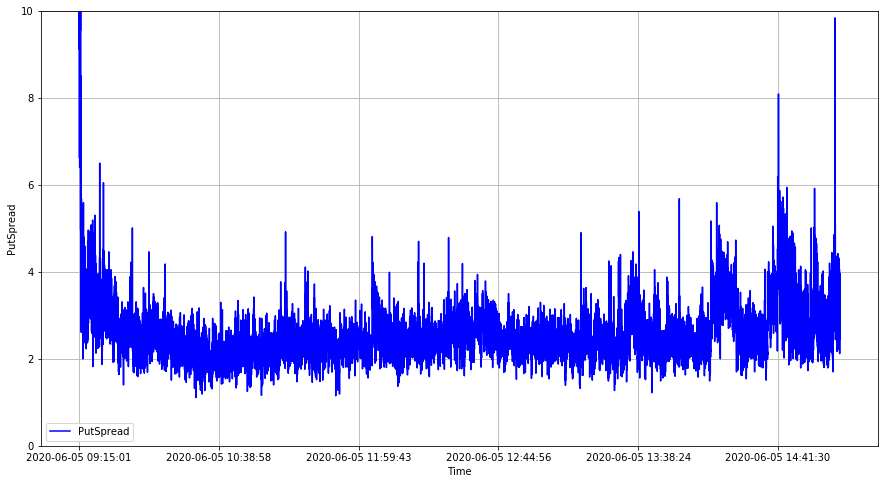

In [127]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 15, 8 # width 10, height 8

ax = df.plot(x='Time', y='PutSpread', style='b-', grid=True)
ax.set_xlabel("Time")
ax.set_ylabel("PutSpread")
ax.set_ylim([0, 10])

In [128]:
test_size = 0.2                 # proportion of dataset to be used as test set
validation_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 500                      # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test


# Get sizes of each of the datasets
num_cv = int(cv_size*len(result))
num_test = int(test_size*len(result))
num_train = len(result) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = result[:num_train]
cv = result[num_train:num_train+num_cv]
train_cv = result[:num_train+num_cv]
test = result[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 16326
num_cv = 5442
num_test = 5442
train.shape = (16326, 4)
cv.shape = (5442, 4)
train_cv.shape = (21768, 4)
test.shape = (5442, 4)


(0, 10)

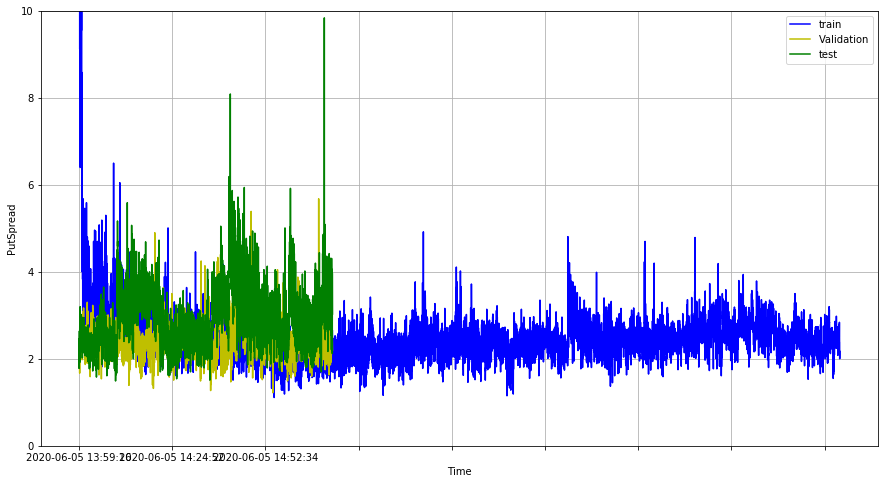

In [131]:
rcParams['figure.figsize'] = 15, 8 # width 10, height 8

ax = train.plot(x='Time', y='PutSpread', style='b-', grid=True)
ax = cv.plot(x='Time', y='PutSpread', style='y-', grid=True, ax=ax)
ax = test.plot(x='Time', y='PutSpread', style='g-', grid=True, ax=ax)
ax.legend(['train', 'Validation', 'test'])
ax.set_xlabel("Time")
ax.set_ylabel("PutSpread")
ax.set_ylim([0, 10])

In [141]:
def get_preds_lin_reg(df, target_col, N, pred_min, offset):
    # Create linear regression object
    regr = LinearRegression(fit_intercept=True)
    pred_list = []
    
    for i in range(offset, len(df[target_col])):
        X_train = np.array(range(len(df[target_col][i:]))) 
        y_train = np.array(df[target_col][i:]) 
        X_train = X_train.reshape(-1, 1)     
        y_train = y_train.reshape(-1, 1)
        regr.fit(X_train, y_train)            # Train the model
        pred = regr.predict(N)
    
        pred_list.append(pred[0][0])  
    
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
        
    return pred_list

def get_mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [142]:
RMSE = []
R2 = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_lin_reg(train_cv, 'PutSpread', N, 0, num_train)
    #est_list = get_preds_mov_avg(train_cv, 'PutSpread', N, 0, num_train)
    len(df[target_col])
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['PutSpread'])))
    R2.append(r2_score(cv['PutSpread'], est_list))
    mape.append(get_mape(cv['PutSpread'], est_list))
print('RMSE = ' + str(RMSE))
print('R2 = ' + str(R2))
print('MAPE = ' + str(mape))
cv.head()

ValueError: Expected 2D array, got scalar array instead:
array=1.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.